<a href="https://colab.research.google.com/github/manikantareddy2k3/wrmproject/blob/main/rainfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.inspection import permutation_importance

# Load datasets
rainfall_data = pd.read_csv('/content/rainfall.csv')
soil_moisture_data = pd.read_csv('/content/sm_Andhrapradesh_2020.csv')

# Convert dates to standard format
rainfall_data['Dates'] = pd.to_datetime(rainfall_data['Dates'], format='%d-%b-%y')
soil_moisture_data['Date'] = pd.to_datetime(soil_moisture_data['Date'], format='%Y/%m/%d')

# Merge datasets on date
merged_data = pd.merge(rainfall_data, soil_moisture_data, left_on='Dates', right_on='Date', how='inner')
merged_data.columns = merged_data.columns.str.strip()
merged_data['Month'] = merged_data['Dates'].dt.month
merged_data['Season'] = merged_data['Month'].apply(lambda x: (x % 12 + 3) // 3)

# Adding random features for demonstration
np.random.seed(42)
merged_data['Temperature'] = np.random.uniform(25, 40, size=len(merged_data))
merged_data['Humidity'] = np.random.uniform(40, 90, size=len(merged_data))
merged_data['Wind_Speed'] = np.random.uniform(0, 10, size=len(merged_data))

# Drop unnecessary columns
merged_data = merged_data.drop(columns=['State Name', 'Dates', 'Date'])
merged_data = pd.get_dummies(merged_data, columns=['DistrictName'], drop_first=True)

# Separate features and target
X = merged_data.drop(columns=['ACTUAL (mm)'])
y = np.log1p(merged_data['ACTUAL (mm)'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Model Training
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=42)

In [ ]:
# Predictions and Performance Metrics
y_pred = model.predict(X_test_scaled)
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 2.4214677217797966
R² Score: 0.6519128259906914
Mean Absolute Error (MAE): 1.1141392242291683


In [ ]:

# Discretize predicted and actual values into categories
y_test_category = y_test_actual.apply(categorize_rainfall)
y_pred_category = pd.Series(y_pred_actual).apply(categorize_rainfall)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_category, y_pred_category, labels=['Low', 'Medium', 'High'])


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test_category, y_pred_category)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 98.53%


Precision (Low, Medium, High): [0.98522167 1.         0.        ]
Recall (Low, Medium, High): [1.         0.18181818 0.        ]
F1-Score (Low, Medium, High): [0.99255583 0.30769231 0.        ]


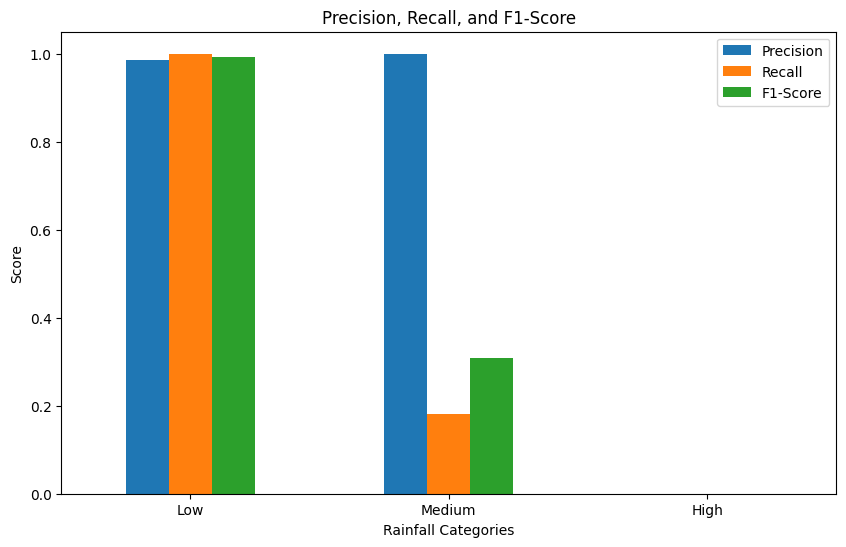

In [ ]:
# Precision, Recall, and F1-Score with zero_division handling
precision = precision_score(y_test_category, y_pred_category, average=None, labels=['Low', 'Medium', 'High'], zero_division=0)
recall = recall_score(y_test_category, y_pred_category, average=None, labels=['Low', 'Medium', 'High'], zero_division=0)
f1 = f1_score(y_test_category, y_pred_category, average=None, labels=['Low', 'Medium', 'High'], zero_division=0)

# Display Results

print(f"Precision (Low, Medium, High): {precision}")
print(f"Recall (Low, Medium, High): {recall}")
print(f"F1-Score (Low, Medium, High): {f1}")

# Plot Precision, Recall, and F1-Score
labels = ['Low', 'Medium', 'High']
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=labels)

metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, and F1-Score')
plt.ylabel('Score')
plt.xlabel('Rainfall Categories')
plt.xticks(rotation=0)
plt.show()


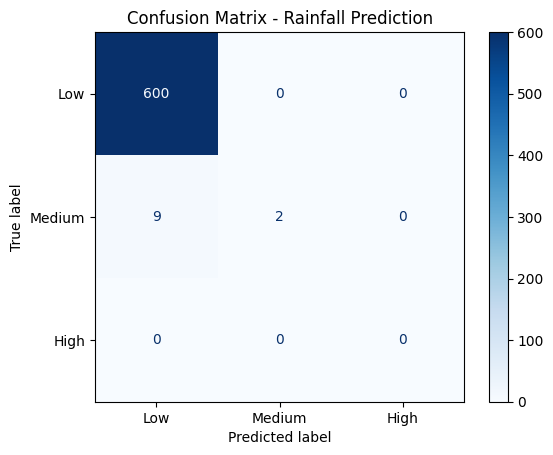

In [ ]:
# Display Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix - Rainfall Prediction")
plt.show()


In [ ]:
# Feature Importance Analysis
importances = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances.importances_mean}).sort_values(by='importance', ascending=False)
print("Top Features by Importance:\n", feature_importances)

def predict_rainfall_and_soil_moisture(date_str, model, scaler, feature_data, convolution_matrix=[0.8, 0.1, 0.1]):
    """
    Predicts rainfall and estimates soil moisture for a given date.
    """
    # Date processing and feature engineering
    date = datetime.strptime(date_str, '%Y-%m-%d')
    month = date.month
    season = (month % 12 + 3) // 3

    # Use recent soil moisture and other data for prediction
    latest_features = feature_data.tail(1).copy()
    latest_features['Month'] = month
    latest_features['Season'] = season

    latest_features_scaled = scaler.transform(latest_features)
    predicted_log_rainfall = model.predict(latest_features_scaled)[0]
    predicted_rainfall = np.expm1(predicted_log_rainfall)

    # Estimate soil moisture using a simple convolution (simulated effect of rainfall on soil moisture)
    # Correct the soil moisture column name
    current_sm = latest_features['Volume Soilmoisture percentage (at 15cm)'].values[0]
    estimated_sm = current_sm + np.dot(convolution_matrix, [predicted_rainfall, current_sm, 0])
    estimated_sm = min(estimated_sm, 100)  # Limit to 100% soil moisture

    return predicted_rainfall, estimated_sm


# Crop suggestion function
def suggest_crop_for_season(season, rainfall):
    if season == 1 and rainfall > 50:
        return "Rice or Groundnut"
    elif season == 2 and rainfall > 40:
        return "Maize or Sugarcane"
    elif season == 3:
        return "Wheat or Barley"
    else:
        return "Millets or Pulses"

Top Features by Importance:
                                         feature  importance
5                                         Month    0.429353
0                                   NORMAL (mm)    0.419522
4      Volume Soilmoisture percentage (at 15cm)    0.128476
2         Average SoilMoisture Volume (at 15cm)    0.112581
6                                        Season    0.100140
1          Average Soilmoisture Level (at 15cm)    0.040309
3   Aggregate Soilmoisture Percentage (at 15cm)    0.027557
13                         DistrictName_KRISHNA    0.006003
21                          DistrictName_Y.S.R.    0.003557
17                      DistrictName_SRIKAKULAM    0.002333
14                         DistrictName_KURNOOL    0.000840
15                        DistrictName_PRAKASAM    0.000594
9                                    Wind_Speed    0.000534
12                          DistrictName_GUNTUR    0.000382
10                        DistrictName_CHITTOOR    0.000000
11         

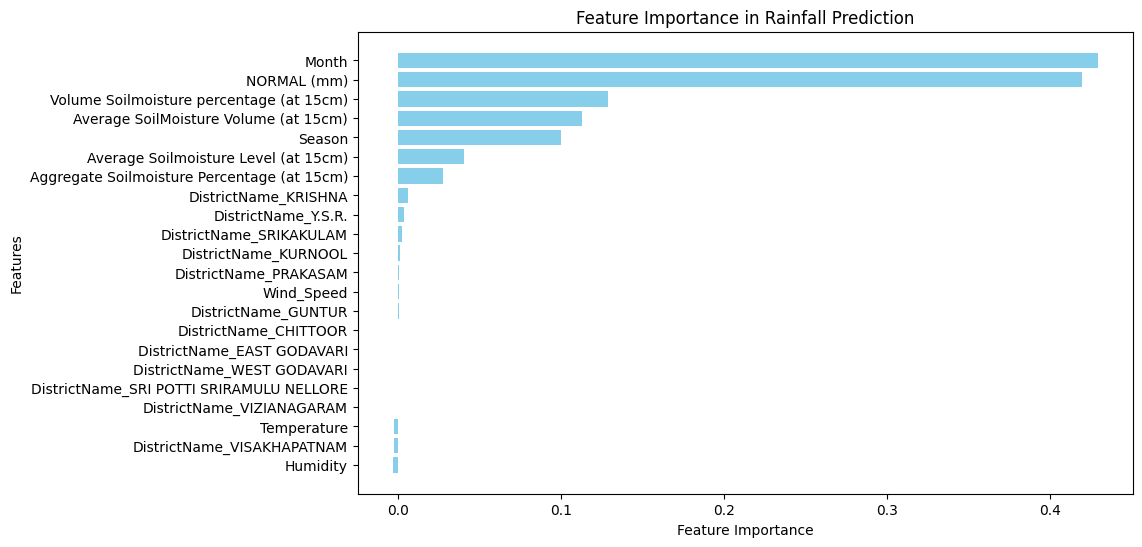

In [ ]:
# Visualization of feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Rainfall Prediction")
plt.gca().invert_yaxis()
plt.show()


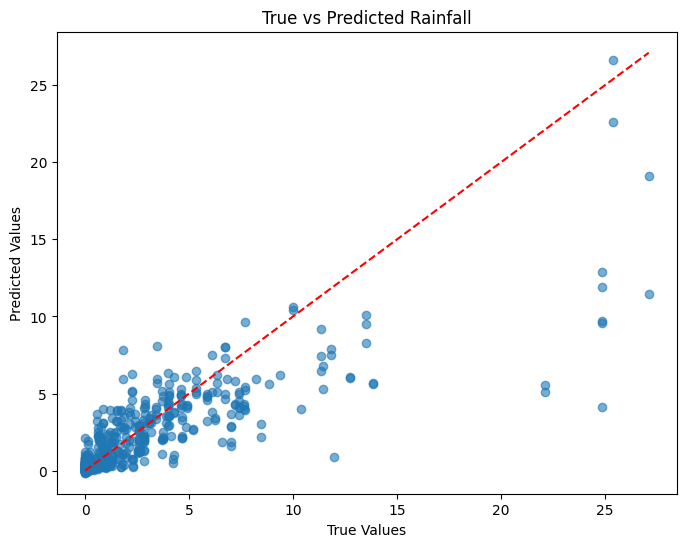

In [ ]:

# True vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Rainfall')
plt.show()

In [ ]:
# User Input and Prediction
user_date = input("Enter a date for prediction (YYYY-MM-DD): ")
predicted_rainfall, estimated_sm = predict_rainfall_and_soil_moisture(user_date, model, scaler, X)
season = (datetime.strptime(user_date, '%Y-%m-%d').month % 12 + 3) // 3
suggested_crop = suggest_crop_for_season(season, predicted_rainfall)

# Output Results
print(f"Predicted rainfall for {user_date}: {predicted_rainfall:.2f} mm")
print(f"Suggested crop for planting: {suggested_crop}")
print(f"Predicted soil moisture level: {estimated_sm:.2f}%")

Enter a date for prediction (YYYY-MM-DD): 2024-01-14
Predicted rainfall for 2024-01-14: 0.35 mm
Suggested crop for planting: Millets or Pulses
Predicted soil moisture level: 46.13%
